# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ecb256da7aac47ab5119a903331db54bae0230aca8a9b6c3d2b3ca45584bee35
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=2369cb5ffbc9c411e62675a3319b7273eb9449d1ad923fe9f3fb30df35a82a3a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = v2.Compose([     v2.Resize(size), 
                                             v2.RandomHorizontalFlip(),  # 随机水平翻转
                                             v2.RandomVerticalFlip(),    # 随机垂直旋转
                                             #v2.RandomRotation(10) ,     # 随机旋转 （-10,10）度
                                             v2.ToImageTensor(), v2.ConvertImageDtype()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 76: 


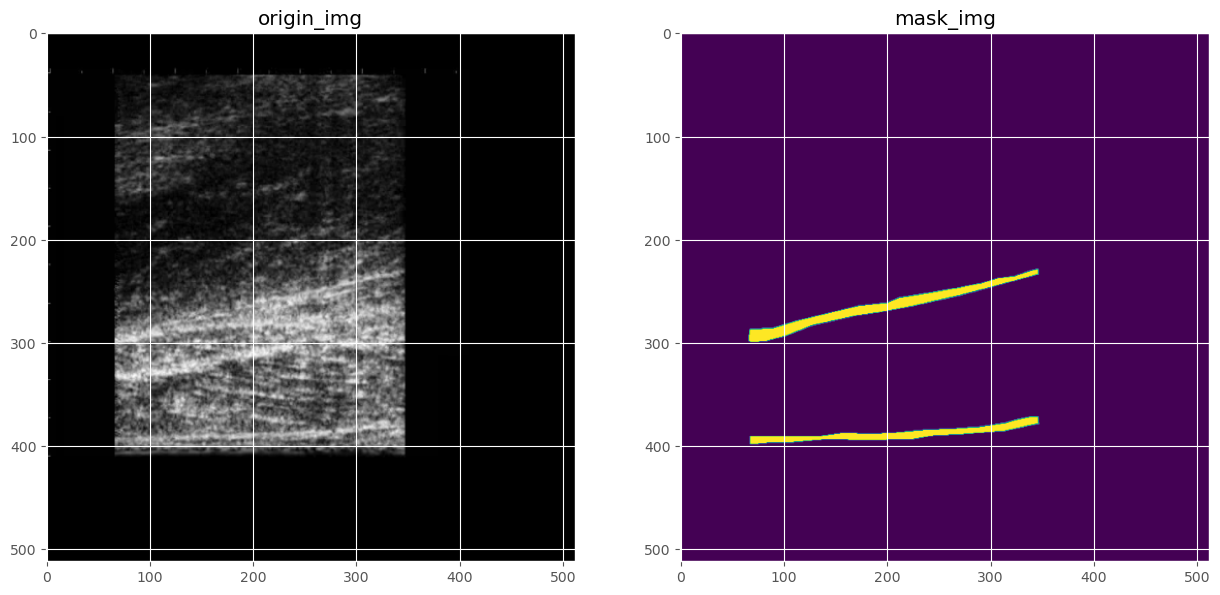

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = v2.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)

sigmoid = nn.Sigmoid()

def train(model, device, 
          epochs: int = 100,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must', notes='对数据进行水平和垂直翻转，无旋转')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        logging.info('Validation Dice score: {}'.format(val_score))
                        
                        predict = sigmoid(masks_pred[0])
                        predict = torch.where(predict>0.5,torch.ones_like(predict),torch.zeros_like(predict))

                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(predict.float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device)

    

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240118_164605-gvizxfsc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fanciful-tree-24
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/U-Net
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/U-Net/runs/gvizxfsc
Epoch 1/100:  20%|█▉        | 90/456 [00:16<01:02,  5.90img/s, loss (batch)=1.56]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.5848232507705688, IoU Score 0.14362676441669464


Epoch 1/100:  39%|███▉      | 180/456 [00:46<00:45,  6.00img/s, loss (batch)=1.46]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.3974852561950684, IoU Score 0.35423046350479126


Epoch 1/100:  59%|█████▉    | 270/456 [01:16<00:32,  5.78img/s, loss (batch)=1.41]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.3524607419967651, IoU Score 0.3708546459674835


Epoch 1/100:  79%|███████▉  | 360/456 [01:46<00:16,  5.69img/s, loss (batch)=1.34]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.55batch/s]


Validation dice loss: 1.2679927349090576, IoU Score 0.492626428604126


Epoch 1/100:  99%|█████████▊| 450/456 [02:17<00:01,  5.67img/s, loss (batch)=1.29]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2967686653137207, IoU Score 0.4385814368724823


Epoch 2/100:  18%|█▊        | 84/456 [00:15<01:03,  5.83img/s, loss (batch)=1.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 1.2139533758163452, IoU Score 0.5488452911376953


Epoch 2/100:  38%|███▊      | 174/456 [00:46<00:49,  5.73img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 1.2014353275299072, IoU Score 0.5518012642860413


Epoch 2/100:  58%|█████▊    | 264/456 [01:17<00:33,  5.65img/s, loss (batch)=1.31]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 1.1893669366836548, IoU Score 0.5718445181846619


Epoch 2/100:  78%|███████▊  | 354/456 [01:49<00:19,  5.20img/s, loss (batch)=1.17]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.44batch/s]


Validation dice loss: 1.1866209506988525, IoU Score 0.5393887758255005


Epoch 2/100:  97%|█████████▋| 444/456 [02:20<00:02,  5.15img/s, loss (batch)=1.17]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.54batch/s]


Validation dice loss: 1.17226243019104, IoU Score 0.5285254120826721


Epoch 3/100:  17%|█▋        | 78/456 [00:13<01:12,  5.22img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.09batch/s]


Validation dice loss: 1.1635563373565674, IoU Score 0.5545129776000977


Epoch 3/100:  37%|███▋      | 168/456 [00:45<00:50,  5.72img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.28batch/s]


Validation dice loss: 1.1517822742462158, IoU Score 0.5715082287788391


Epoch 3/100:  57%|█████▋    | 258/456 [01:16<00:34,  5.80img/s, loss (batch)=1.23]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.41batch/s]


Validation dice loss: 1.1442927122116089, IoU Score 0.5758489370346069


Epoch 3/100:  76%|███████▋  | 348/456 [01:48<00:19,  5.68img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.43batch/s]


Validation dice loss: 1.1551486253738403, IoU Score 0.4997388422489166


Epoch 3/100:  96%|█████████▌| 438/456 [02:18<00:03,  5.82img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.1498318910598755, IoU Score 0.5515055656433105


Epoch 4/100:  16%|█▌        | 72/456 [00:12<01:06,  5.80img/s, loss (batch)=1.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.1441090106964111, IoU Score 0.5841147303581238


Epoch 4/100:  36%|███▌      | 162/456 [00:42<00:51,  5.67img/s, loss (batch)=1.19]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.126281499862671, IoU Score 0.5901899933815002


Epoch 4/100:  55%|█████▌    | 252/456 [01:13<00:35,  5.73img/s, loss (batch)=1.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.1198586225509644, IoU Score 0.5311145782470703


Epoch 4/100:  75%|███████▌  | 342/456 [01:43<00:20,  5.66img/s, loss (batch)=1.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.127469778060913, IoU Score 0.5677239894866943


Epoch 4/100:  95%|█████████▍| 432/456 [02:14<00:04,  5.75img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1035516262054443, IoU Score 0.5871641039848328


Epoch 5/100:  14%|█▍        | 66/456 [00:11<01:08,  5.70img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.1138886213302612, IoU Score 0.47502946853637695


Epoch 5/100:  34%|███▍      | 156/456 [00:41<00:51,  5.79img/s, loss (batch)=1.06] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.0960170030593872, IoU Score 0.5680569410324097


Epoch 5/100:  54%|█████▍    | 246/456 [01:12<00:35,  5.86img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.0987446308135986, IoU Score 0.5545604228973389


Epoch 5/100:  74%|███████▎  | 336/456 [01:42<00:20,  5.75img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 1.1072105169296265, IoU Score 0.5475459694862366


Epoch 5/100:  93%|█████████▎| 426/456 [02:12<00:05,  5.80img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.0667365789413452, IoU Score 0.5827985405921936


Epoch 6/100:  13%|█▎        | 60/456 [00:10<01:07,  5.85img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.0763866901397705, IoU Score 0.5902147889137268


Epoch 6/100:  33%|███▎      | 150/456 [00:40<00:53,  5.72img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.1122499704360962, IoU Score 0.4314737021923065


Epoch 6/100:  53%|█████▎    | 240/456 [01:10<00:36,  5.86img/s, loss (batch)=0.997]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.0747138261795044, IoU Score 0.5369762182235718


Epoch 6/100:  72%|███████▏  | 330/456 [01:41<00:21,  5.75img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.0719587802886963, IoU Score 0.5716730356216431


Epoch 6/100:  92%|█████████▏| 420/456 [02:11<00:06,  5.65img/s, loss (batch)=0.939]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.06415855884552, IoU Score 0.5611995458602905


Epoch 7/100:  12%|█▏        | 54/456 [00:09<01:08,  5.84img/s, loss (batch)=1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.0906225442886353, IoU Score 0.40706124901771545


Epoch 7/100:  32%|███▏      | 144/456 [00:39<00:54,  5.74img/s, loss (batch)=1.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.0708003044128418, IoU Score 0.5598105788230896


Epoch 7/100:  51%|█████▏    | 234/456 [01:10<00:39,  5.56img/s, loss (batch)=1.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.04609215259552, IoU Score 0.5988940000534058


Epoch 7/100:  71%|███████   | 324/456 [01:40<00:23,  5.70img/s, loss (batch)=0.971]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.0701121091842651, IoU Score 0.5484004020690918


Epoch 7/100:  91%|█████████ | 414/456 [02:11<00:07,  5.82img/s, loss (batch)=0.881]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.0864096879959106, IoU Score 0.4537633955478668


Epoch 8/100:  11%|█         | 48/456 [00:08<01:10,  5.79img/s, loss (batch)=0.951]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.0811545848846436, IoU Score 0.44395995140075684


Epoch 8/100:  30%|███       | 138/456 [00:38<00:55,  5.72img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 1.0512759685516357, IoU Score 0.5346028804779053


Epoch 8/100:  50%|█████     | 228/456 [01:09<00:39,  5.74img/s, loss (batch)=0.967]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.0349345207214355, IoU Score 0.5893012881278992


Epoch 8/100:  70%|██████▉   | 318/456 [01:39<00:24,  5.69img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.032306432723999, IoU Score 0.5570982098579407


Epoch 8/100:  89%|████████▉ | 408/456 [02:09<00:08,  5.83img/s, loss (batch)=0.921]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.0274159908294678, IoU Score 0.5936604738235474


Epoch 9/100:   9%|▉         | 42/456 [00:07<01:11,  5.78img/s, loss (batch)=0.912]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.061046838760376, IoU Score 0.513194739818573


Epoch 9/100:  29%|██▉       | 132/456 [00:37<01:03,  5.09img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.0639113187789917, IoU Score 0.47951194643974304


Epoch 9/100:  49%|████▊     | 222/456 [01:08<00:41,  5.71img/s, loss (batch)=0.919]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.0289297103881836, IoU Score 0.5647070407867432


Epoch 9/100:  68%|██████▊   | 312/456 [01:38<00:25,  5.73img/s, loss (batch)=1.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.021793007850647, IoU Score 0.5738426446914673


Epoch 9/100:  88%|████████▊ | 402/456 [02:08<00:09,  5.77img/s, loss (batch)=0.974]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.012913703918457, IoU Score 0.5561918020248413


Epoch 10/100:   8%|▊         | 36/456 [00:06<01:12,  5.80img/s, loss (batch)=0.86] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.02165949344635, IoU Score 0.5336077213287354


Epoch 10/100:  28%|██▊       | 126/456 [00:36<00:57,  5.71img/s, loss (batch)=1.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.0303152799606323, IoU Score 0.5182693600654602


Epoch 10/100:  47%|████▋     | 216/456 [01:06<00:41,  5.73img/s, loss (batch)=0.93]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.0039114952087402, IoU Score 0.5871578454971313


Epoch 10/100:  67%|██████▋   | 306/456 [01:37<00:26,  5.69img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.0258557796478271, IoU Score 0.5182875394821167


Epoch 10/100:  87%|████████▋ | 396/456 [02:07<00:10,  5.80img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.9869760870933533, IoU Score 0.5867416858673096


Epoch 11/100:   7%|▋         | 30/456 [00:05<01:15,  5.68img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.9731028079986572, IoU Score 0.5742505788803101


Epoch 11/100:  26%|██▋       | 120/456 [00:35<00:59,  5.62img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.9518422484397888, IoU Score 0.5875431895256042


Epoch 11/100:  46%|████▌     | 210/456 [01:06<00:42,  5.80img/s, loss (batch)=0.84]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.9724260568618774, IoU Score 0.5482678413391113


Epoch 11/100:  66%|██████▌   | 300/456 [01:36<00:27,  5.66img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.9376778602600098, IoU Score 0.5727487206459045


Epoch 11/100:  86%|████████▌ | 390/456 [02:06<00:11,  5.73img/s, loss (batch)=0.816]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 0.9066938757896423, IoU Score 0.5822325944900513


Epoch 12/100:   5%|▌         | 24/456 [00:04<01:14,  5.76img/s, loss (batch)=0.826]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 0.8940009474754333, IoU Score 0.6058330535888672


Epoch 12/100:  25%|██▌       | 114/456 [00:35<00:59,  5.74img/s, loss (batch)=0.933]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.37batch/s]


Validation dice loss: 0.9120189547538757, IoU Score 0.5483089089393616


Epoch 12/100:  45%|████▍     | 204/456 [01:06<00:43,  5.77img/s, loss (batch)=0.934]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.44batch/s]


Validation dice loss: 0.8595279455184937, IoU Score 0.5743958353996277


Epoch 12/100:  64%|██████▍   | 294/456 [01:37<00:28,  5.67img/s, loss (batch)=0.939]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 0.8664500117301941, IoU Score 0.565167248249054


Epoch 12/100:  84%|████████▍ | 384/456 [02:07<00:12,  5.67img/s, loss (batch)=0.74] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.48batch/s]


Validation dice loss: 0.8867499828338623, IoU Score 0.4801406264305115


Epoch 13/100:   4%|▍         | 18/456 [00:03<01:19,  5.50img/s, loss (batch)=0.781]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.43batch/s]


Validation dice loss: 0.8116090893745422, IoU Score 0.5695988535881042


Epoch 13/100:  24%|██▎       | 108/456 [00:33<01:01,  5.62img/s, loss (batch)=0.729]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.44batch/s]


Validation dice loss: 0.8536832332611084, IoU Score 0.5127759575843811


Epoch 13/100:  43%|████▎     | 198/456 [01:04<00:45,  5.68img/s, loss (batch)=0.751]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.43batch/s]


Validation dice loss: 0.8066783547401428, IoU Score 0.5908448696136475


Epoch 13/100:  63%|██████▎   | 288/456 [01:35<00:28,  5.81img/s, loss (batch)=0.742]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.40batch/s]


Validation dice loss: 0.8281852006912231, IoU Score 0.5386667847633362


Epoch 13/100:  83%|████████▎ | 378/456 [02:06<00:13,  5.79img/s, loss (batch)=0.599]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.41batch/s]


Validation dice loss: 0.7729870080947876, IoU Score 0.5789462327957153


Epoch 14/100:   3%|▎         | 12/456 [00:02<01:19,  5.56img/s, loss (batch)=0.708]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.8029780387878418, IoU Score 0.5464248061180115


Epoch 14/100:  22%|██▏       | 102/456 [00:32<01:01,  5.72img/s, loss (batch)=0.609]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.7430189847946167, IoU Score 0.6230291128158569


Epoch 14/100:  42%|████▏     | 192/456 [01:02<00:45,  5.81img/s, loss (batch)=0.635]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.732134997844696, IoU Score 0.5957481861114502


Epoch 14/100:  62%|██████▏   | 282/456 [01:33<00:31,  5.61img/s, loss (batch)=0.594]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.7189936637878418, IoU Score 0.6023577451705933


Epoch 14/100:  82%|████████▏ | 372/456 [02:03<00:14,  5.71img/s, loss (batch)=0.663]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.751984715461731, IoU Score 0.55728679895401


Epoch 15/100:   1%|▏         | 6/456 [00:01<01:17,  5.82img/s, loss (batch)=0.623]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.737758457660675, IoU Score 0.556090772151947


Epoch 15/100:  21%|██        | 96/456 [00:31<01:02,  5.77img/s, loss (batch)=0.518]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.7126197218894958, IoU Score 0.5669931769371033


Epoch 15/100:  41%|████      | 186/456 [01:01<00:47,  5.71img/s, loss (batch)=0.687]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.6758986711502075, IoU Score 0.5858102440834045


Epoch 15/100:  61%|██████    | 276/456 [01:31<00:31,  5.79img/s, loss (batch)=0.507]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.7099875807762146, IoU Score 0.547153115272522


Epoch 15/100:  80%|████████  | 366/456 [02:02<00:15,  5.75img/s, loss (batch)=0.637]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.7236636281013489, IoU Score 0.5309686660766602


Epoch 15/100: 100%|██████████| 456/456 [02:32<00:00,  5.78img/s, loss (batch)=0.533]

Validation round


Epoch 15/100: 100%|██████████| 456/456 [02:46<00:00,  2.73img/s, loss (batch)=0.533]


Validation dice loss: 0.6653797030448914, IoU Score 0.5750138759613037


Epoch 16/100:  20%|█▉        | 90/456 [00:15<01:03,  5.81img/s, loss (batch)=0.514]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6263018250465393, IoU Score 0.6105333566665649


Epoch 16/100:  39%|███▉      | 180/456 [00:46<00:48,  5.74img/s, loss (batch)=0.615]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6671739220619202, IoU Score 0.5666457414627075


Epoch 16/100:  59%|█████▉    | 270/456 [01:16<00:31,  5.81img/s, loss (batch)=0.459]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.6544475555419922, IoU Score 0.57281494140625


Epoch 16/100:  79%|███████▉  | 360/456 [01:46<00:16,  5.68img/s, loss (batch)=0.6]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.6082860231399536, IoU Score 0.6188951134681702


Epoch 16/100:  99%|█████████▊| 450/456 [02:17<00:01,  5.74img/s, loss (batch)=0.543]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.7388811111450195, IoU Score 0.4366092383861542


Epoch 17/100:  18%|█▊        | 84/456 [00:14<01:05,  5.68img/s, loss (batch)=0.625]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5911062955856323, IoU Score 0.618571400642395


Epoch 17/100:  38%|███▊      | 174/456 [00:45<00:49,  5.74img/s, loss (batch)=0.551]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.61257004737854, IoU Score 0.5843119025230408


Epoch 17/100:  58%|█████▊    | 264/456 [01:15<00:33,  5.74img/s, loss (batch)=0.626]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6872106194496155, IoU Score 0.47260960936546326


Epoch 17/100:  78%|███████▊  | 354/456 [01:45<00:17,  5.80img/s, loss (batch)=0.552]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6803590059280396, IoU Score 0.48634493350982666


Epoch 17/100:  97%|█████████▋| 444/456 [02:15<00:02,  5.74img/s, loss (batch)=0.582]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6289250254631042, IoU Score 0.5280627608299255


Epoch 18/100:  17%|█▋        | 78/456 [00:13<01:05,  5.73img/s, loss (batch)=0.736]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.7681267857551575, IoU Score 0.40332457423210144


Epoch 18/100:  37%|███▋      | 168/456 [00:43<00:50,  5.73img/s, loss (batch)=0.488]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6053946018218994, IoU Score 0.5473015308380127


Epoch 18/100:  57%|█████▋    | 258/456 [01:14<00:35,  5.63img/s, loss (batch)=0.598]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.6089287996292114, IoU Score 0.5479288101196289


Epoch 18/100:  76%|███████▋  | 348/456 [01:44<00:18,  5.72img/s, loss (batch)=0.408]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.6418692469596863, IoU Score 0.49753624200820923


Epoch 18/100:  96%|█████████▌| 438/456 [02:15<00:03,  5.67img/s, loss (batch)=0.486]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5343905091285706, IoU Score 0.5980424284934998


Epoch 19/100:  16%|█▌        | 72/456 [00:12<01:07,  5.68img/s, loss (batch)=0.748]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6044466495513916, IoU Score 0.5321002006530762


Epoch 19/100:  36%|███▌      | 162/456 [00:42<00:51,  5.74img/s, loss (batch)=0.533]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.5412638783454895, IoU Score 0.5918827652931213


Epoch 19/100:  55%|█████▌    | 252/456 [01:13<00:36,  5.64img/s, loss (batch)=0.445]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5170995593070984, IoU Score 0.615127444267273


Epoch 19/100:  75%|███████▌  | 342/456 [01:43<00:20,  5.60img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5961045622825623, IoU Score 0.5258148312568665


Epoch 19/100:  95%|█████████▍| 432/456 [02:14<00:04,  5.71img/s, loss (batch)=0.349]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6225382089614868, IoU Score 0.49629953503608704


Epoch 20/100:  14%|█▍        | 66/456 [00:11<01:07,  5.80img/s, loss (batch)=0.302]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5054191946983337, IoU Score 0.6129245162010193


Epoch 20/100:  34%|███▍      | 156/456 [00:41<00:52,  5.76img/s, loss (batch)=0.579]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.5583353042602539, IoU Score 0.5659465789794922


Epoch 20/100:  54%|█████▍    | 246/456 [01:12<00:36,  5.80img/s, loss (batch)=0.469]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5252406597137451, IoU Score 0.5846694111824036


Epoch 20/100:  74%|███████▎  | 336/456 [01:42<00:20,  5.73img/s, loss (batch)=0.475]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5142443180084229, IoU Score 0.5830695033073425


Epoch 20/100:  93%|█████████▎| 426/456 [02:12<00:05,  5.74img/s, loss (batch)=0.38] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.6346157789230347, IoU Score 0.4702471196651459


Epoch 21/100:  13%|█▎        | 60/456 [00:10<01:08,  5.82img/s, loss (batch)=0.388]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5312073230743408, IoU Score 0.5646296143531799


Epoch 21/100:  33%|███▎      | 150/456 [00:40<00:52,  5.79img/s, loss (batch)=0.358]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5847635865211487, IoU Score 0.5136074423789978


Epoch 21/100:  53%|█████▎    | 240/456 [01:10<00:37,  5.71img/s, loss (batch)=0.436]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.624912440776825, IoU Score 0.4732198417186737


Epoch 21/100:  72%|███████▏  | 330/456 [01:41<00:21,  5.83img/s, loss (batch)=0.368]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4658108055591583, IoU Score 0.6087636947631836


Epoch 21/100:  92%|█████████▏| 420/456 [02:11<00:06,  5.75img/s, loss (batch)=0.383]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.6473621129989624, IoU Score 0.45013734698295593


Epoch 22/100:  12%|█▏        | 54/456 [00:09<01:10,  5.73img/s, loss (batch)=0.458]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5917408466339111, IoU Score 0.4944877028465271


Epoch 22/100:  32%|███▏      | 144/456 [00:39<00:54,  5.73img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5743594169616699, IoU Score 0.49959295988082886


Epoch 22/100:  51%|█████▏    | 234/456 [01:09<00:39,  5.63img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5554789304733276, IoU Score 0.5210545659065247


Epoch 22/100:  71%|███████   | 324/456 [01:40<00:22,  5.80img/s, loss (batch)=0.863]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6899598836898804, IoU Score 0.39999905228614807


Epoch 22/100:  91%|█████████ | 414/456 [02:10<00:07,  5.80img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6279433965682983, IoU Score 0.44274160265922546


Epoch 23/100:  11%|█         | 48/456 [00:08<01:12,  5.63img/s, loss (batch)=0.447]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.44batch/s]


Validation dice loss: 0.6406905055046082, IoU Score 0.446090966463089


Epoch 23/100:  30%|███       | 138/456 [00:39<01:03,  5.03img/s, loss (batch)=0.319]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.41batch/s]


Validation dice loss: 0.5525891184806824, IoU Score 0.49809762835502625


Epoch 23/100:  50%|█████     | 228/456 [01:10<00:40,  5.64img/s, loss (batch)=0.41] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.46498945355415344, IoU Score 0.6027064919471741


Epoch 23/100:  70%|██████▉   | 318/456 [01:40<00:23,  5.79img/s, loss (batch)=0.287]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.42963576316833496, IoU Score 0.6170711517333984


Epoch 23/100:  89%|████████▉ | 408/456 [02:10<00:08,  5.79img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4986504912376404, IoU Score 0.5556113719940186


Epoch 24/100:   9%|▉         | 42/456 [00:07<01:10,  5.85img/s, loss (batch)=0.782]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.49889957904815674, IoU Score 0.5639311671257019


Epoch 24/100:  29%|██▉       | 132/456 [00:37<00:56,  5.71img/s, loss (batch)=0.304]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5728309154510498, IoU Score 0.4849734902381897


Epoch 24/100:  49%|████▊     | 222/456 [01:07<00:41,  5.64img/s, loss (batch)=0.437]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 0.4090025722980499, IoU Score 0.6406587958335876


Epoch 24/100:  68%|██████▊   | 312/456 [01:38<00:25,  5.62img/s, loss (batch)=0.344]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5336890816688538, IoU Score 0.5256878137588501


Epoch 24/100:  88%|████████▊ | 402/456 [02:08<00:09,  5.82img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4184051752090454, IoU Score 0.6221287250518799


Epoch 25/100:   8%|▊         | 36/456 [00:06<01:13,  5.70img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.47374802827835083, IoU Score 0.5760105848312378


Epoch 25/100:  28%|██▊       | 126/456 [00:36<00:58,  5.61img/s, loss (batch)=0.465]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4727826416492462, IoU Score 0.5758727192878723


Epoch 25/100:  47%|████▋     | 216/456 [01:07<00:42,  5.58img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.47032830119132996, IoU Score 0.5705760717391968


Epoch 25/100:  67%|██████▋   | 306/456 [01:37<00:26,  5.77img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.41797202825546265, IoU Score 0.6250593662261963


Epoch 25/100:  87%|████████▋ | 396/456 [02:08<00:10,  5.74img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 0.5314713716506958, IoU Score 0.5169170498847961


Epoch 26/100:   7%|▋         | 30/456 [00:05<01:15,  5.68img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5091407895088196, IoU Score 0.5309957265853882


Epoch 26/100:  26%|██▋       | 120/456 [00:35<00:59,  5.69img/s, loss (batch)=0.465]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.44459906220436096, IoU Score 0.5898578763008118


Epoch 26/100:  46%|████▌     | 210/456 [01:06<00:43,  5.64img/s, loss (batch)=0.683]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4472180902957916, IoU Score 0.585227370262146


Epoch 26/100:  66%|██████▌   | 300/456 [01:36<00:27,  5.65img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.7211417555809021, IoU Score 0.3588474690914154


Epoch 26/100:  86%|████████▌ | 390/456 [02:06<00:11,  5.66img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4771842062473297, IoU Score 0.5560813546180725


Epoch 27/100:   5%|▌         | 24/456 [00:04<01:14,  5.78img/s, loss (batch)=0.317]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5837854146957397, IoU Score 0.46289533376693726


Epoch 27/100:  25%|██▌       | 114/456 [00:34<01:08,  4.99img/s, loss (batch)=0.733]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4516793191432953, IoU Score 0.5732675194740295


Epoch 27/100:  45%|████▍     | 204/456 [01:04<00:43,  5.81img/s, loss (batch)=0.262]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.5322100520133972, IoU Score 0.5147803425788879


Epoch 27/100:  64%|██████▍   | 294/456 [01:35<00:28,  5.73img/s, loss (batch)=0.355]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.5114331841468811, IoU Score 0.5282487869262695


Epoch 27/100:  84%|████████▍ | 384/456 [02:05<00:12,  5.75img/s, loss (batch)=0.615]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.5009790062904358, IoU Score 0.5275641679763794


Epoch 28/100:   4%|▍         | 18/456 [00:03<01:15,  5.82img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.51batch/s]


Validation dice loss: 0.5852698683738708, IoU Score 0.4628802239894867


Epoch 28/100:  24%|██▎       | 108/456 [00:34<01:07,  5.15img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.54batch/s]


Validation dice loss: 0.4413500726222992, IoU Score 0.5788468718528748


Epoch 28/100:  43%|████▎     | 198/456 [01:05<00:44,  5.75img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.46723008155822754, IoU Score 0.5513131022453308


Epoch 28/100:  63%|██████▎   | 288/456 [01:35<00:28,  5.82img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4424949586391449, IoU Score 0.5740329027175903


Epoch 28/100:  83%|████████▎ | 378/456 [02:06<00:13,  5.82img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4956952631473541, IoU Score 0.532352089881897


Epoch 29/100:   3%|▎         | 12/456 [00:02<01:17,  5.72img/s, loss (batch)=0.384]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5266023874282837, IoU Score 0.5058807730674744


Epoch 29/100:  22%|██▏       | 102/456 [00:32<01:00,  5.85img/s, loss (batch)=0.326]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.44767245650291443, IoU Score 0.5655369162559509


Epoch 29/100:  42%|████▏     | 192/456 [01:02<00:46,  5.68img/s, loss (batch)=0.779]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4495573043823242, IoU Score 0.5675540566444397


Epoch 29/100:  62%|██████▏   | 282/456 [01:32<00:30,  5.66img/s, loss (batch)=0.428]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4559371769428253, IoU Score 0.5619707703590393


Epoch 29/100:  82%|████████▏ | 372/456 [02:03<00:14,  5.82img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.4177004098892212, IoU Score 0.5897464156150818


Epoch 30/100:   1%|▏         | 6/456 [00:01<01:17,  5.77img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.6352047920227051, IoU Score 0.41760414838790894


Epoch 30/100:  21%|██        | 96/456 [00:31<01:02,  5.74img/s, loss (batch)=0.3]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5358062982559204, IoU Score 0.4893523156642914


Epoch 30/100:  41%|████      | 186/456 [01:01<00:47,  5.65img/s, loss (batch)=0.316]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.43559539318084717, IoU Score 0.5766932368278503


Epoch 30/100:  61%|██████    | 276/456 [01:32<00:31,  5.78img/s, loss (batch)=0.276]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6513217091560364, IoU Score 0.40996599197387695


Epoch 30/100:  80%|████████  | 366/456 [02:02<00:15,  5.70img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.38804471492767334, IoU Score 0.6083657741546631


Epoch 30/100: 100%|██████████| 456/456 [02:32<00:00,  5.75img/s, loss (batch)=0.174]

Validation round


Epoch 30/100: 100%|██████████| 456/456 [02:47<00:00,  2.72img/s, loss (batch)=0.174]


Validation dice loss: 0.4050811529159546, IoU Score 0.6062607765197754


Epoch 31/100:  20%|█▉        | 90/456 [00:15<01:03,  5.77img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3652269244194031, IoU Score 0.6362578272819519


Epoch 31/100:  39%|███▉      | 180/456 [00:45<00:48,  5.64img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.37854552268981934, IoU Score 0.6165297627449036


Epoch 31/100:  59%|█████▉    | 270/456 [01:16<00:34,  5.44img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.5042294859886169, IoU Score 0.5192392468452454


Epoch 31/100:  79%|███████▉  | 360/456 [01:46<00:16,  5.69img/s, loss (batch)=0.536]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4505292475223541, IoU Score 0.5571688413619995


Epoch 31/100:  99%|█████████▊| 450/456 [02:16<00:01,  5.68img/s, loss (batch)=0.247]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5105276703834534, IoU Score 0.501883864402771


Epoch 32/100:  18%|█▊        | 84/456 [00:14<01:04,  5.78img/s, loss (batch)=0.31]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4194030165672302, IoU Score 0.5828585028648376


Epoch 32/100:  38%|███▊      | 174/456 [00:44<00:49,  5.72img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.495809406042099, IoU Score 0.520064115524292


Epoch 32/100:  58%|█████▊    | 264/456 [01:15<00:33,  5.69img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.38628026843070984, IoU Score 0.6110676527023315


Epoch 32/100:  78%|███████▊  | 354/456 [01:45<00:17,  5.68img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.38280925154685974, IoU Score 0.6210001111030579


Epoch 32/100:  97%|█████████▋| 444/456 [02:15<00:02,  5.78img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.5534369945526123, IoU Score 0.47474199533462524


Epoch 33/100:  17%|█▋        | 78/456 [00:13<01:07,  5.62img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.45384567975997925, IoU Score 0.5539090633392334


Epoch 33/100:  37%|███▋      | 168/456 [00:44<00:49,  5.86img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6388465166091919, IoU Score 0.416558176279068


Epoch 33/100:  57%|█████▋    | 258/456 [01:14<00:33,  5.83img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.39821526408195496, IoU Score 0.6059188842773438


Epoch 33/100:  76%|███████▋  | 348/456 [01:44<00:18,  5.84img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.41723859310150146, IoU Score 0.5866444110870361


Epoch 33/100:  96%|█████████▌| 438/456 [02:14<00:03,  5.83img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.39850884675979614, IoU Score 0.599281370639801


Epoch 34/100:  16%|█▌        | 72/456 [00:12<01:07,  5.67img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.37673869729042053, IoU Score 0.621370255947113


Epoch 34/100:  36%|███▌      | 162/456 [00:42<00:50,  5.83img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.5129173398017883, IoU Score 0.5091341733932495


Epoch 34/100:  55%|█████▌    | 252/456 [01:13<00:35,  5.70img/s, loss (batch)=0.887]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6057888269424438, IoU Score 0.4343271553516388


Epoch 34/100:  75%|███████▌  | 342/456 [01:43<00:19,  5.74img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5560147762298584, IoU Score 0.4651617109775543


Epoch 34/100:  95%|█████████▍| 432/456 [02:13<00:04,  5.77img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.38245031237602234, IoU Score 0.6057714819908142


Epoch 35/100:  14%|█▍        | 66/456 [00:11<01:07,  5.78img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.3795434832572937, IoU Score 0.6150431036949158


Epoch 35/100:  34%|███▍      | 156/456 [00:41<00:51,  5.85img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.44710680842399597, IoU Score 0.5571351647377014


Epoch 35/100:  54%|█████▍    | 246/456 [01:12<00:37,  5.68img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6540387272834778, IoU Score 0.39719998836517334


Epoch 35/100:  74%|███████▎  | 336/456 [01:42<00:20,  5.83img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.41844436526298523, IoU Score 0.5712296366691589


Epoch 35/100:  93%|█████████▎| 426/456 [02:13<00:05,  5.68img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5729947686195374, IoU Score 0.4513687491416931


Epoch 36/100:  13%|█▎        | 60/456 [00:10<01:08,  5.78img/s, loss (batch)=0.27] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3440858721733093, IoU Score 0.6487224102020264


Epoch 36/100:  33%|███▎      | 150/456 [00:40<00:54,  5.65img/s, loss (batch)=0.265]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.5481488108634949, IoU Score 0.4782097339630127


Epoch 36/100:  53%|█████▎    | 240/456 [01:11<00:37,  5.72img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.36597874760627747, IoU Score 0.6248763203620911


Epoch 36/100:  72%|███████▏  | 330/456 [01:41<00:21,  5.80img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4265264868736267, IoU Score 0.5643300414085388


Epoch 36/100:  92%|█████████▏| 420/456 [02:12<00:06,  5.76img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.41045647859573364, IoU Score 0.5822287201881409


Epoch 37/100:  12%|█▏        | 54/456 [00:09<01:10,  5.69img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4933294355869293, IoU Score 0.5179882049560547


Epoch 37/100:  32%|███▏      | 144/456 [00:39<00:55,  5.63img/s, loss (batch)=0.355]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.36771196126937866, IoU Score 0.6209867596626282


Epoch 37/100:  51%|█████▏    | 234/456 [01:09<00:39,  5.67img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5795056819915771, IoU Score 0.4439769983291626


Epoch 37/100:  71%|███████   | 324/456 [01:40<00:22,  5.74img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.38130202889442444, IoU Score 0.6133924722671509


Epoch 37/100:  91%|█████████ | 414/456 [02:10<00:07,  5.68img/s, loss (batch)=0.311]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5928257703781128, IoU Score 0.44208306074142456


Epoch 38/100:  11%|█         | 48/456 [00:08<01:10,  5.76img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.49316003918647766, IoU Score 0.5129933953285217


Epoch 38/100:  30%|███       | 138/456 [00:38<00:54,  5.82img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.42850184440612793, IoU Score 0.5678274631500244


Epoch 38/100:  50%|█████     | 228/456 [01:09<00:40,  5.64img/s, loss (batch)=0.651]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.37950268387794495, IoU Score 0.6118804812431335


Epoch 38/100:  70%|██████▉   | 318/456 [01:39<00:24,  5.72img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.36608144640922546, IoU Score 0.615569531917572


Epoch 38/100:  89%|████████▉ | 408/456 [02:09<00:08,  5.88img/s, loss (batch)=0.384]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3441307246685028, IoU Score 0.6398782134056091


Epoch 39/100:   9%|▉         | 42/456 [00:07<01:12,  5.67img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.46522289514541626, IoU Score 0.5374745726585388


Epoch 39/100:  29%|██▉       | 132/456 [00:37<00:56,  5.74img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.36114153265953064, IoU Score 0.6270355582237244


Epoch 39/100:  49%|████▊     | 222/456 [01:07<00:40,  5.71img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.47973623871803284, IoU Score 0.5156711339950562


Epoch 39/100:  68%|██████▊   | 312/456 [01:38<00:24,  5.82img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.36499813199043274, IoU Score 0.6201798915863037


Epoch 39/100:  88%|████████▊ | 402/456 [02:08<00:09,  5.73img/s, loss (batch)=0.27] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5928322076797485, IoU Score 0.4446999132633209


Epoch 40/100:   8%|▊         | 36/456 [00:06<01:12,  5.79img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5825992226600647, IoU Score 0.45407792925834656


Epoch 40/100:  28%|██▊       | 126/456 [00:36<00:57,  5.70img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4474349915981293, IoU Score 0.5430873036384583


Epoch 40/100:  47%|████▋     | 216/456 [01:07<00:42,  5.64img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5219088196754456, IoU Score 0.48840001225471497


Epoch 40/100:  67%|██████▋   | 306/456 [01:37<00:26,  5.63img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.5687885880470276, IoU Score 0.4495662748813629


Epoch 40/100:  87%|████████▋ | 396/456 [02:08<00:10,  5.71img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4796617031097412, IoU Score 0.5209812521934509


Epoch 41/100:   7%|▋         | 30/456 [00:05<01:13,  5.76img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.41301652789115906, IoU Score 0.5747423768043518


Epoch 41/100:  26%|██▋       | 120/456 [00:35<00:59,  5.69img/s, loss (batch)=1.28] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4045751690864563, IoU Score 0.5846940279006958


Epoch 41/100:  46%|████▌     | 210/456 [01:05<00:42,  5.75img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.5870804786682129, IoU Score 0.44928616285324097


Epoch 41/100:  66%|██████▌   | 300/456 [01:36<00:27,  5.60img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5280508995056152, IoU Score 0.4935348629951477


Epoch 41/100:  86%|████████▌ | 390/456 [02:06<00:11,  5.63img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4309840202331543, IoU Score 0.5641494393348694


Epoch 42/100:   5%|▌         | 24/456 [00:04<01:14,  5.77img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4396037459373474, IoU Score 0.5533393621444702


Epoch 42/100:  25%|██▌       | 114/456 [00:34<01:01,  5.54img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.7235020995140076, IoU Score 0.35092875361442566


Epoch 42/100:  45%|████▍     | 204/456 [01:04<00:43,  5.74img/s, loss (batch)=0.31] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4773017466068268, IoU Score 0.5298671722412109


Epoch 42/100:  64%|██████▍   | 294/456 [01:35<00:28,  5.75img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 0.4516918361186981, IoU Score 0.5471221804618835


Epoch 42/100:  84%|████████▍ | 384/456 [02:05<00:12,  5.69img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5723088979721069, IoU Score 0.4654160737991333


Epoch 43/100:   4%|▍         | 18/456 [00:03<01:15,  5.77img/s, loss (batch)=0.6]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5813952088356018, IoU Score 0.44840148091316223


Epoch 43/100:  24%|██▎       | 108/456 [00:33<01:02,  5.61img/s, loss (batch)=0.312]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5366906523704529, IoU Score 0.4769986569881439


Epoch 43/100:  43%|████▎     | 198/456 [01:03<00:47,  5.42img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5495829582214355, IoU Score 0.4772171676158905


Epoch 43/100:  63%|██████▎   | 288/456 [01:34<00:28,  5.85img/s, loss (batch)=0.345]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5207463502883911, IoU Score 0.4914650321006775


Epoch 43/100:  83%|████████▎ | 378/456 [02:04<00:13,  5.70img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4704379737377167, IoU Score 0.5286818146705627


Epoch 44/100:   3%|▎         | 12/456 [00:02<01:17,  5.75img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.3938842713832855, IoU Score 0.5876361727714539


Epoch 44/100:  22%|██▏       | 102/456 [00:32<01:02,  5.64img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.40605050325393677, IoU Score 0.5770087838172913


Epoch 44/100:  42%|████▏     | 192/456 [01:02<00:45,  5.75img/s, loss (batch)=0.35] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.374506413936615, IoU Score 0.6054348945617676


Epoch 44/100:  62%|██████▏   | 282/456 [01:32<00:30,  5.73img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.42196694016456604, IoU Score 0.5682955384254456


Epoch 44/100:  82%|████████▏ | 372/456 [02:03<00:15,  5.40img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.406085342168808, IoU Score 0.5803170204162598


Epoch 45/100:   1%|▏         | 6/456 [00:01<01:18,  5.75img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4857456386089325, IoU Score 0.5104725956916809


Epoch 45/100:  21%|██        | 96/456 [00:31<01:02,  5.78img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3793942630290985, IoU Score 0.5986675024032593


Epoch 45/100:  41%|████      | 186/456 [01:01<00:47,  5.72img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.35720905661582947, IoU Score 0.6293367743492126


Epoch 45/100:  61%|██████    | 276/456 [01:31<00:31,  5.70img/s, loss (batch)=0.748]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.41421669721603394, IoU Score 0.5716536641120911


Epoch 45/100:  80%|████████  | 366/456 [02:02<00:17,  5.17img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.3564120829105377, IoU Score 0.6212512254714966


Epoch 45/100: 100%|██████████| 456/456 [02:32<00:00,  5.81img/s, loss (batch)=0.296]

Validation round


Epoch 45/100: 100%|██████████| 456/456 [02:47<00:00,  2.73img/s, loss (batch)=0.296]


Validation dice loss: 0.35140788555145264, IoU Score 0.6196818351745605


Epoch 46/100:  20%|█▉        | 90/456 [00:15<01:03,  5.77img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 0.4745701551437378, IoU Score 0.522352397441864


Epoch 46/100:  39%|███▉      | 180/456 [00:46<00:47,  5.79img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5150012373924255, IoU Score 0.501352071762085


Epoch 46/100:  59%|█████▉    | 270/456 [01:16<00:31,  5.83img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.3956157863140106, IoU Score 0.581497073173523


Epoch 46/100:  79%|███████▉  | 360/456 [01:46<00:16,  5.74img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.524143636226654, IoU Score 0.481025367975235


Epoch 46/100:  99%|█████████▊| 450/456 [02:17<00:01,  5.65img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5495062470436096, IoU Score 0.46658673882484436


Epoch 47/100:  18%|█▊        | 84/456 [00:14<01:04,  5.80img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5282962322235107, IoU Score 0.48726508021354675


Epoch 47/100:  38%|███▊      | 174/456 [00:45<00:49,  5.65img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.35066646337509155, IoU Score 0.6232975721359253


Epoch 47/100:  58%|█████▊    | 264/456 [01:15<00:33,  5.78img/s, loss (batch)=0.691]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.374883770942688, IoU Score 0.6106652021408081


Epoch 47/100:  78%|███████▊  | 354/456 [01:46<00:18,  5.58img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5883731842041016, IoU Score 0.4443369507789612


Epoch 47/100:  97%|█████████▋| 444/456 [02:16<00:02,  5.79img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5278768539428711, IoU Score 0.4841526746749878


Epoch 48/100:  17%|█▋        | 78/456 [00:13<01:06,  5.67img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.55batch/s]


Validation dice loss: 0.39958181977272034, IoU Score 0.584607720375061


Epoch 48/100:  37%|███▋      | 168/456 [00:44<00:50,  5.70img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4657628834247589, IoU Score 0.5388123393058777


Epoch 48/100:  57%|█████▋    | 258/456 [01:14<00:34,  5.76img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6656690239906311, IoU Score 0.3982338011264801


Epoch 48/100:  76%|███████▋  | 348/456 [01:45<00:19,  5.53img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.5503398776054382, IoU Score 0.4773043096065521


Epoch 48/100:  96%|█████████▌| 438/456 [02:15<00:03,  5.61img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5948058366775513, IoU Score 0.44024646282196045


Epoch 49/100:  16%|█▌        | 72/456 [00:12<01:11,  5.36img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.36588263511657715, IoU Score 0.6135166883468628


Epoch 49/100:  36%|███▌      | 162/456 [00:42<00:50,  5.78img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5172874927520752, IoU Score 0.4938354790210724


Epoch 49/100:  55%|█████▌    | 252/456 [01:13<00:35,  5.70img/s, loss (batch)=0.881]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.40636810660362244, IoU Score 0.5762454271316528


Epoch 49/100:  75%|███████▌  | 342/456 [01:43<00:19,  5.83img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4220714271068573, IoU Score 0.5649820566177368


Epoch 49/100:  95%|█████████▍| 432/456 [02:14<00:04,  5.81img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.6555488705635071, IoU Score 0.39131075143814087


Epoch 50/100:  14%|█▍        | 66/456 [00:11<01:08,  5.72img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4353456497192383, IoU Score 0.5575053095817566


Epoch 50/100:  34%|███▍      | 156/456 [00:41<00:52,  5.75img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.560158371925354, IoU Score 0.46988728642463684


Epoch 50/100:  54%|█████▍    | 246/456 [01:12<00:36,  5.71img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3717403709888458, IoU Score 0.6072384715080261


Epoch 50/100:  74%|███████▎  | 336/456 [01:42<00:20,  5.72img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.44402235746383667, IoU Score 0.5398133397102356


Epoch 50/100:  93%|█████████▎| 426/456 [02:12<00:05,  5.79img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.36065873503685, IoU Score 0.6163026690483093


Epoch 51/100:  13%|█▎        | 60/456 [00:10<01:09,  5.72img/s, loss (batch)=0.738]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.4869597256183624, IoU Score 0.5208338499069214


Epoch 51/100:  33%|███▎      | 150/456 [00:40<00:53,  5.71img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5814066529273987, IoU Score 0.45034098625183105


Epoch 51/100:  53%|█████▎    | 240/456 [01:11<00:38,  5.64img/s, loss (batch)=0.364]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 0.4500877559185028, IoU Score 0.5404489040374756


Epoch 51/100:  72%|███████▏  | 330/456 [01:41<00:22,  5.67img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.47398507595062256, IoU Score 0.5357353091239929


Epoch 51/100:  92%|█████████▏| 420/456 [02:11<00:06,  5.65img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4751448631286621, IoU Score 0.5248420238494873


Epoch 52/100:  12%|█▏        | 54/456 [00:09<01:10,  5.69img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4257870316505432, IoU Score 0.5547532439231873


Epoch 52/100:  32%|███▏      | 144/456 [00:39<00:54,  5.73img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.4892885684967041, IoU Score 0.5107883214950562


Epoch 52/100:  51%|█████▏    | 234/456 [01:10<00:39,  5.69img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.5154654383659363, IoU Score 0.4923522174358368


Epoch 52/100:  71%|███████   | 324/456 [01:40<00:22,  5.79img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.3676932454109192, IoU Score 0.610378623008728


Epoch 52/100:  91%|█████████ | 414/456 [02:10<00:07,  5.80img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4209267497062683, IoU Score 0.5577513575553894


Epoch 53/100:  11%|█         | 48/456 [00:08<01:11,  5.71img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4488773047924042, IoU Score 0.5384364128112793


Epoch 53/100:  30%|███       | 138/456 [00:38<00:55,  5.76img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.43039894104003906, IoU Score 0.5601511001586914


Epoch 53/100:  50%|█████     | 228/456 [01:09<00:40,  5.62img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.43543869256973267, IoU Score 0.552234947681427


Epoch 53/100:  70%|██████▉   | 318/456 [01:39<00:24,  5.67img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.49641165137290955, IoU Score 0.5068545937538147


Epoch 53/100:  89%|████████▉ | 408/456 [02:09<00:08,  5.76img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3460911214351654, IoU Score 0.6334079504013062


Epoch 54/100:   9%|▉         | 42/456 [00:07<01:11,  5.76img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.46909967064857483, IoU Score 0.5359172821044922


Epoch 54/100:  29%|██▉       | 132/456 [00:37<00:56,  5.76img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4308868944644928, IoU Score 0.5553407073020935


Epoch 54/100:  49%|████▊     | 222/456 [01:08<00:41,  5.69img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.34937965869903564, IoU Score 0.6296118497848511


Epoch 54/100:  68%|██████▊   | 312/456 [01:38<00:24,  5.83img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4473671317100525, IoU Score 0.5425099730491638


Epoch 54/100:  88%|████████▊ | 402/456 [02:08<00:09,  5.60img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.3205015957355499, IoU Score 0.6486457586288452


Epoch 55/100:   8%|▊         | 36/456 [00:06<01:12,  5.77img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.39728274941444397, IoU Score 0.5798851847648621


Epoch 55/100:  28%|██▊       | 126/456 [00:37<00:57,  5.78img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.6245970129966736, IoU Score 0.42271527647972107


Epoch 55/100:  47%|████▋     | 216/456 [01:07<00:41,  5.73img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.3913952112197876, IoU Score 0.5934303998947144


Epoch 55/100:  67%|██████▋   | 306/456 [01:37<00:26,  5.70img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.40984588861465454, IoU Score 0.5785188674926758


Epoch 55/100:  87%|████████▋ | 396/456 [02:08<00:10,  5.69img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.41815185546875, IoU Score 0.5718495845794678


Epoch 56/100:   7%|▋         | 30/456 [00:05<01:13,  5.79img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.41556301712989807, IoU Score 0.5770981907844543


Epoch 56/100:  26%|██▋       | 120/456 [00:35<00:59,  5.69img/s, loss (batch)=0.843]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6400681138038635, IoU Score 0.411095529794693


Epoch 56/100:  46%|████▌     | 210/456 [01:05<00:42,  5.74img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.42432859539985657, IoU Score 0.5646305084228516


Epoch 56/100:  66%|██████▌   | 300/456 [01:36<00:27,  5.63img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 0.6352984309196472, IoU Score 0.40191513299942017


Epoch 56/100:  86%|████████▌ | 390/456 [02:06<00:11,  5.76img/s, loss (batch)=0.147]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 0.5560054183006287, IoU Score 0.4772488474845886


Epoch 57/100:   5%|▌         | 24/456 [00:04<01:15,  5.70img/s, loss (batch)=0.798]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.3814348578453064, IoU Score 0.5998308658599854


Epoch 57/100:  25%|██▌       | 114/456 [00:34<00:59,  5.75img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4665476083755493, IoU Score 0.5339965224266052


Epoch 57/100:  45%|████▍     | 204/456 [01:05<00:43,  5.80img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.46448495984077454, IoU Score 0.529992401599884


Epoch 57/100:  64%|██████▍   | 294/456 [01:35<00:27,  5.82img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5061530470848083, IoU Score 0.4995642602443695


Epoch 57/100:  84%|████████▍ | 384/456 [02:05<00:12,  5.59img/s, loss (batch)=0.244]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6140668392181396, IoU Score 0.434346079826355


Epoch 58/100:   4%|▍         | 18/456 [00:03<01:16,  5.72img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.484169602394104, IoU Score 0.5175819396972656


Epoch 58/100:  24%|██▎       | 108/456 [00:33<01:01,  5.68img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5184513926506042, IoU Score 0.4901326596736908


Epoch 58/100:  43%|████▎     | 198/456 [01:03<00:44,  5.76img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5657646059989929, IoU Score 0.46523526310920715


Epoch 58/100:  63%|██████▎   | 288/456 [01:33<00:28,  5.80img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.45919349789619446, IoU Score 0.5331525206565857


Epoch 58/100:  83%|████████▎ | 378/456 [02:04<00:13,  5.79img/s, loss (batch)=0.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5155505537986755, IoU Score 0.4992105960845947


Epoch 59/100:   3%|▎         | 12/456 [00:02<01:16,  5.81img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4633316695690155, IoU Score 0.5361827611923218


Epoch 59/100:  22%|██▏       | 102/456 [00:32<01:03,  5.61img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.51739102602005, IoU Score 0.5007474422454834


Epoch 59/100:  42%|████▏     | 192/456 [01:02<00:46,  5.67img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.4279038906097412, IoU Score 0.554839015007019


Epoch 59/100:  62%|██████▏   | 282/456 [01:33<00:30,  5.77img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5689574480056763, IoU Score 0.46167832612991333


Epoch 59/100:  82%|████████▏ | 372/456 [02:03<00:14,  5.82img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4276602566242218, IoU Score 0.5562518239021301


Epoch 60/100:   1%|▏         | 6/456 [00:01<01:18,  5.76img/s, loss (batch)=0.761]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.43479931354522705, IoU Score 0.555104672908783


Epoch 60/100:  21%|██        | 96/456 [00:31<01:03,  5.67img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.36497122049331665, IoU Score 0.6151632070541382


Epoch 60/100:  41%|████      | 186/456 [01:01<00:47,  5.66img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.38080552220344543, IoU Score 0.606734037399292


Epoch 60/100:  61%|██████    | 276/456 [01:32<00:32,  5.47img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.43958809971809387, IoU Score 0.554664671421051


Epoch 60/100:  80%|████████  | 366/456 [02:02<00:15,  5.66img/s, loss (batch)=0.784]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.5368704795837402, IoU Score 0.49027779698371887


Epoch 60/100: 100%|██████████| 456/456 [02:33<00:00,  5.84img/s, loss (batch)=0.243]

Validation round


Epoch 60/100: 100%|██████████| 456/456 [02:47<00:00,  2.72img/s, loss (batch)=0.243]


Validation dice loss: 0.6500559449195862, IoU Score 0.4039873778820038


Epoch 61/100:  20%|█▉        | 90/456 [00:15<01:03,  5.79img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.39347177743911743, IoU Score 0.5830296277999878


Epoch 61/100:  39%|███▉      | 180/456 [00:46<00:48,  5.75img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.663912296295166, IoU Score 0.39022278785705566


Epoch 61/100:  59%|█████▉    | 270/456 [01:16<00:32,  5.81img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.37556320428848267, IoU Score 0.5986930131912231


Epoch 61/100:  79%|███████▉  | 360/456 [01:46<00:16,  5.68img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.3756246566772461, IoU Score 0.6025236248970032


Epoch 61/100:  99%|█████████▊| 450/456 [02:16<00:01,  5.76img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.6512376070022583, IoU Score 0.3959651291370392


Epoch 62/100:  18%|█▊        | 84/456 [00:14<01:04,  5.78img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.4452400803565979, IoU Score 0.5521569848060608


Epoch 62/100:  38%|███▊      | 174/456 [00:44<00:49,  5.64img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5046597123146057, IoU Score 0.5099819302558899


Epoch 62/100:  58%|█████▊    | 264/456 [01:15<00:32,  5.86img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.3978106677532196, IoU Score 0.5881354808807373


Epoch 62/100:  78%|███████▊  | 354/456 [01:45<00:17,  5.74img/s, loss (batch)=0.147]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5999262928962708, IoU Score 0.4284646809101105


Epoch 62/100:  97%|█████████▋| 444/456 [02:16<00:02,  5.75img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5472626090049744, IoU Score 0.47424209117889404


Epoch 63/100:  17%|█▋        | 78/456 [00:13<01:05,  5.74img/s, loss (batch)=0.572]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.647554874420166, IoU Score 0.4101930856704712


Epoch 63/100:  37%|███▋      | 168/456 [00:44<00:49,  5.80img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.3515740931034088, IoU Score 0.6266478300094604


Epoch 63/100:  57%|█████▋    | 258/456 [01:14<00:34,  5.77img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.5019537210464478, IoU Score 0.5031580924987793


Epoch 63/100:  76%|███████▋  | 348/456 [01:44<00:18,  5.82img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4382813572883606, IoU Score 0.5423550009727478


Epoch 63/100:  96%|█████████▌| 438/456 [02:15<00:03,  5.74img/s, loss (batch)=0.139]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.49376994371414185, IoU Score 0.50788414478302


Epoch 64/100:  16%|█▌        | 72/456 [00:12<01:07,  5.67img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6113293170928955, IoU Score 0.428749144077301


Epoch 64/100:  36%|███▌      | 162/456 [00:42<00:52,  5.63img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4423317313194275, IoU Score 0.5524604916572571


Epoch 64/100:  55%|█████▌    | 252/456 [01:13<00:35,  5.72img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.45662373304367065, IoU Score 0.5318523049354553


Epoch 64/100:  75%|███████▌  | 342/456 [01:43<00:19,  5.85img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.7018154263496399, IoU Score 0.3714087903499603


Epoch 64/100:  95%|█████████▍| 432/456 [02:13<00:04,  5.78img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5459304451942444, IoU Score 0.4787408113479614


Epoch 65/100:  14%|█▍        | 66/456 [00:11<01:07,  5.76img/s, loss (batch)=0.696]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3577304780483246, IoU Score 0.6213632822036743


Epoch 65/100:  34%|███▍      | 156/456 [00:41<00:51,  5.78img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4165654182434082, IoU Score 0.5716179609298706


Epoch 65/100:  54%|█████▍    | 246/456 [01:12<00:36,  5.73img/s, loss (batch)=0.138] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3810741603374481, IoU Score 0.6016008853912354


Epoch 65/100:  74%|███████▎  | 336/456 [01:42<00:21,  5.69img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.3920292556285858, IoU Score 0.5932060480117798


Epoch 65/100:  93%|█████████▎| 426/456 [02:12<00:05,  5.68img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.3448905050754547, IoU Score 0.629426896572113


Epoch 66/100:  13%|█▎        | 60/456 [00:10<01:08,  5.80img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.3382049798965454, IoU Score 0.6392464637756348


Epoch 66/100:  33%|███▎      | 150/456 [00:40<00:52,  5.80img/s, loss (batch)=0.577]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.57441246509552, IoU Score 0.46330076456069946


Epoch 66/100:  53%|█████▎    | 240/456 [01:10<00:37,  5.77img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.35020697116851807, IoU Score 0.6266531348228455


Epoch 66/100:  72%|███████▏  | 330/456 [01:41<00:22,  5.63img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.49371784925460815, IoU Score 0.5197429656982422


Epoch 66/100:  92%|█████████▏| 420/456 [02:11<00:06,  5.74img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.5366911292076111, IoU Score 0.4886828660964966


Epoch 67/100:  12%|█▏        | 54/456 [00:09<01:09,  5.77img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.44045794010162354, IoU Score 0.5473408699035645


Epoch 67/100:  32%|███▏      | 144/456 [00:39<00:54,  5.72img/s, loss (batch)=0.789]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.5113304853439331, IoU Score 0.49935317039489746


Epoch 67/100:  51%|█████▏    | 234/456 [01:10<00:38,  5.73img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.38535353541374207, IoU Score 0.5985302329063416


Epoch 67/100:  71%|███████   | 324/456 [01:40<00:23,  5.66img/s, loss (batch)=0.248]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4690588414669037, IoU Score 0.5298213958740234


Epoch 67/100:  91%|█████████ | 414/456 [02:10<00:07,  5.62img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.6124712824821472, IoU Score 0.43667200207710266


Epoch 68/100:  11%|█         | 48/456 [00:08<01:11,  5.70img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.5625877380371094, IoU Score 0.466819167137146


Epoch 68/100:  30%|███       | 138/456 [00:38<00:55,  5.75img/s, loss (batch)=0.595] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.43367016315460205, IoU Score 0.556300938129425


Epoch 68/100:  50%|█████     | 228/456 [01:09<00:39,  5.78img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.49747347831726074, IoU Score 0.5168232321739197


Epoch 68/100:  70%|██████▉   | 318/456 [01:39<00:24,  5.73img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4710698425769806, IoU Score 0.5344176888465881


Epoch 68/100:  89%|████████▉ | 408/456 [02:10<00:08,  5.76img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4842769503593445, IoU Score 0.5202194452285767


Epoch 69/100:   9%|▉         | 42/456 [00:07<01:13,  5.60img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4161486029624939, IoU Score 0.5785272717475891


Epoch 69/100:  29%|██▉       | 132/456 [00:37<00:56,  5.74img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4286206066608429, IoU Score 0.5626097321510315


Epoch 69/100:  49%|████▊     | 222/456 [01:08<00:40,  5.72img/s, loss (batch)=0.0936]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.35590824484825134, IoU Score 0.6232573986053467


Epoch 69/100:  68%|██████▊   | 312/456 [01:38<00:24,  5.82img/s, loss (batch)=0.151] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.557468593120575, IoU Score 0.4720752239227295


Epoch 69/100:  88%|████████▊ | 402/456 [02:08<00:09,  5.70img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.39650818705558777, IoU Score 0.5803061127662659


Epoch 70/100:   8%|▊         | 36/456 [00:06<01:14,  5.65img/s, loss (batch)=0.152] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5942795276641846, IoU Score 0.45507046580314636


Epoch 70/100:  28%|██▊       | 126/456 [00:36<00:58,  5.67img/s, loss (batch)=0.304]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.631340503692627, IoU Score 0.41019830107688904


Epoch 70/100:  47%|████▋     | 216/456 [01:06<00:41,  5.80img/s, loss (batch)=0.0823]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4976727366447449, IoU Score 0.5053699612617493


Epoch 70/100:  67%|██████▋   | 306/456 [01:37<00:26,  5.76img/s, loss (batch)=0.171] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.3760887682437897, IoU Score 0.6081523895263672


Epoch 70/100:  87%|████████▋ | 396/456 [02:07<00:10,  5.93img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.3210916817188263, IoU Score 0.6555338501930237


Epoch 71/100:   7%|▋         | 30/456 [00:05<01:13,  5.82img/s, loss (batch)=0.583]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3714427053928375, IoU Score 0.605419933795929


Epoch 71/100:  26%|██▋       | 120/456 [00:35<00:59,  5.66img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.49038949608802795, IoU Score 0.5205742716789246


Epoch 71/100:  46%|████▌     | 210/456 [01:06<00:42,  5.80img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.43373602628707886, IoU Score 0.5578233003616333


Epoch 71/100:  66%|██████▌   | 300/456 [01:36<00:27,  5.60img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.49793967604637146, IoU Score 0.5138689279556274


Epoch 71/100:  86%|████████▌ | 390/456 [02:06<00:11,  5.67img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.5511232018470764, IoU Score 0.4851853847503662


Epoch 72/100:   5%|▌         | 24/456 [00:04<01:16,  5.62img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5830119252204895, IoU Score 0.4606449007987976


Epoch 72/100:  25%|██▌       | 114/456 [00:34<00:59,  5.74img/s, loss (batch)=0.0907]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.38628870248794556, IoU Score 0.5951043367385864


Epoch 72/100:  45%|████▍     | 204/456 [01:05<00:44,  5.71img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.35403767228126526, IoU Score 0.623188316822052


Epoch 72/100:  64%|██████▍   | 294/456 [01:35<00:28,  5.67img/s, loss (batch)=0.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 0.5875773429870605, IoU Score 0.4718838930130005


Epoch 72/100:  84%|████████▍ | 384/456 [02:06<00:12,  5.72img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.4471420645713806, IoU Score 0.5556479692459106


Epoch 73/100:   4%|▍         | 18/456 [00:03<01:15,  5.81img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.31349965929985046, IoU Score 0.6570358872413635


Epoch 73/100:  24%|██▎       | 108/456 [00:33<00:59,  5.85img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.33141863346099854, IoU Score 0.6477804780006409


Epoch 73/100:  43%|████▎     | 198/456 [01:03<00:45,  5.72img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.439140260219574, IoU Score 0.5518041849136353


Epoch 73/100:  63%|██████▎   | 288/456 [01:34<00:29,  5.67img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4986763000488281, IoU Score 0.5213266611099243


Epoch 73/100:  83%|████████▎ | 378/456 [02:04<00:13,  5.74img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.49220356345176697, IoU Score 0.5234485864639282


Epoch 74/100:   3%|▎         | 12/456 [00:02<01:17,  5.74img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.5745289325714111, IoU Score 0.47464925050735474


Epoch 74/100:  22%|██▏       | 102/456 [00:32<01:00,  5.84img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5391135811805725, IoU Score 0.4791058897972107


Epoch 74/100:  42%|████▏     | 192/456 [01:02<00:45,  5.75img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4917457103729248, IoU Score 0.5194735527038574


Epoch 74/100:  62%|██████▏   | 282/456 [01:33<00:30,  5.65img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.43558281660079956, IoU Score 0.5541366934776306


Epoch 74/100:  82%|████████▏ | 372/456 [02:03<00:14,  5.79img/s, loss (batch)=0.399]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5282268524169922, IoU Score 0.4930519163608551


Epoch 75/100:   1%|▏         | 6/456 [00:01<01:17,  5.83img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5129203200340271, IoU Score 0.5063381195068359


Epoch 75/100:  21%|██        | 96/456 [00:31<01:03,  5.70img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.3824673295021057, IoU Score 0.5971249938011169


Epoch 75/100:  41%|████      | 186/456 [01:01<00:48,  5.56img/s, loss (batch)=0.0931]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4598563313484192, IoU Score 0.5411038398742676


Epoch 75/100:  61%|██████    | 276/456 [01:32<00:31,  5.75img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.3648858070373535, IoU Score 0.6118842363357544


Epoch 75/100:  80%|████████  | 366/456 [02:02<00:15,  5.69img/s, loss (batch)=0.685]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5229544639587402, IoU Score 0.5039666891098022


Epoch 75/100: 100%|██████████| 456/456 [02:32<00:00,  5.78img/s, loss (batch)=0.107]

Validation round


Epoch 75/100: 100%|██████████| 456/456 [02:47<00:00,  2.73img/s, loss (batch)=0.107]


Validation dice loss: 0.38495928049087524, IoU Score 0.5925700068473816


Epoch 76/100:  20%|█▉        | 90/456 [00:15<01:03,  5.81img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.6121281981468201, IoU Score 0.44247016310691833


Epoch 76/100:  39%|███▉      | 180/456 [00:46<00:47,  5.85img/s, loss (batch)=0.141] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.45376816391944885, IoU Score 0.5412303805351257


Epoch 76/100:  59%|█████▉    | 270/456 [01:16<00:32,  5.70img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 0.6447517275810242, IoU Score 0.4082326292991638


Epoch 76/100:  79%|███████▉  | 360/456 [01:47<00:17,  5.64img/s, loss (batch)=0.831]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.5581855773925781, IoU Score 0.47843828797340393


Epoch 76/100:  99%|█████████▊| 450/456 [02:17<00:01,  5.86img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.38454827666282654, IoU Score 0.6145926713943481


Epoch 77/100:  18%|█▊        | 84/456 [00:14<01:05,  5.72img/s, loss (batch)=0.285]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4692258834838867, IoU Score 0.5261144042015076


Epoch 77/100:  38%|███▊      | 174/456 [00:44<00:49,  5.73img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4888821244239807, IoU Score 0.5191287994384766


Epoch 77/100:  58%|█████▊    | 264/456 [01:15<00:33,  5.72img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4220013916492462, IoU Score 0.5706477165222168


Epoch 77/100:  78%|███████▊  | 354/456 [01:45<00:18,  5.66img/s, loss (batch)=0.403]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.3711651563644409, IoU Score 0.6088611483573914


Epoch 77/100:  97%|█████████▋| 444/456 [02:16<00:02,  5.67img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.43374305963516235, IoU Score 0.5605238676071167


Epoch 78/100:  17%|█▋        | 78/456 [00:13<01:04,  5.87img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5818050503730774, IoU Score 0.475337415933609


Epoch 78/100:  37%|███▋      | 168/456 [00:43<00:50,  5.75img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 0.49375441670417786, IoU Score 0.5264497399330139


Epoch 78/100:  57%|█████▋    | 258/456 [01:14<00:35,  5.62img/s, loss (batch)=0.694]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.49381721019744873, IoU Score 0.5178831815719604


Epoch 78/100:  76%|███████▋  | 348/456 [01:44<00:18,  5.71img/s, loss (batch)=0.0953]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.4662993252277374, IoU Score 0.5292647480964661


Epoch 78/100:  96%|█████████▌| 438/456 [02:15<00:03,  5.67img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5472822189331055, IoU Score 0.4768671691417694


Epoch 79/100:  16%|█▌        | 72/456 [00:12<01:05,  5.83img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5431088209152222, IoU Score 0.49250853061676025


Epoch 79/100:  36%|███▌      | 162/456 [00:42<00:51,  5.74img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.45776814222335815, IoU Score 0.5468915700912476


Epoch 79/100:  55%|█████▌    | 252/456 [01:13<00:36,  5.62img/s, loss (batch)=0.269] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.39451706409454346, IoU Score 0.5877237319946289


Epoch 79/100:  75%|███████▌  | 342/456 [01:43<00:19,  5.72img/s, loss (batch)=0.293] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5865936875343323, IoU Score 0.4603472948074341


Epoch 79/100:  95%|█████████▍| 432/456 [02:14<00:04,  5.70img/s, loss (batch)=0.089]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5249741077423096, IoU Score 0.49661916494369507


Epoch 80/100:  14%|█▍        | 66/456 [00:11<01:10,  5.57img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.515583872795105, IoU Score 0.5013891458511353


Epoch 80/100:  34%|███▍      | 156/456 [00:41<00:52,  5.73img/s, loss (batch)=0.139]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.441177636384964, IoU Score 0.5585302114486694


Epoch 80/100:  54%|█████▍    | 246/456 [01:12<00:36,  5.69img/s, loss (batch)=0.0874]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.6387205123901367, IoU Score 0.4240744113922119


Epoch 80/100:  74%|███████▎  | 336/456 [01:42<00:20,  5.74img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.371368944644928, IoU Score 0.6118757724761963


Epoch 80/100:  93%|█████████▎| 426/456 [02:12<00:05,  5.72img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4924095571041107, IoU Score 0.5212699174880981


Epoch 81/100:  13%|█▎        | 60/456 [00:10<01:08,  5.75img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.3975165784358978, IoU Score 0.5853984951972961


Epoch 81/100:  33%|███▎      | 150/456 [00:40<00:53,  5.77img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.3867014944553375, IoU Score 0.6011347770690918


Epoch 81/100:  53%|█████▎    | 240/456 [01:11<00:37,  5.79img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5385812520980835, IoU Score 0.4748876690864563


Epoch 81/100:  72%|███████▏  | 330/456 [01:41<00:22,  5.65img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.6290228366851807, IoU Score 0.42584457993507385


Epoch 81/100:  92%|█████████▏| 420/456 [02:11<00:06,  5.69img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.49935394525527954, IoU Score 0.5216672420501709


Epoch 82/100:  12%|█▏        | 54/456 [00:09<01:09,  5.79img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.6521540284156799, IoU Score 0.4221608638763428


Epoch 82/100:  32%|███▏      | 144/456 [00:39<00:54,  5.71img/s, loss (batch)=0.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.44730353355407715, IoU Score 0.5421560406684875


Epoch 82/100:  51%|█████▏    | 234/456 [01:09<00:38,  5.80img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.4674024283885956, IoU Score 0.5272400379180908


Epoch 82/100:  71%|███████   | 324/456 [01:39<00:22,  5.76img/s, loss (batch)=0.094]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5475000143051147, IoU Score 0.4823795258998871


Epoch 82/100:  91%|█████████ | 414/456 [02:10<00:07,  5.62img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.4573548138141632, IoU Score 0.5441910028457642


Epoch 83/100:  11%|█         | 48/456 [00:08<01:10,  5.76img/s, loss (batch)=0.0936]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5809621810913086, IoU Score 0.4709564745426178


Epoch 83/100:  30%|███       | 138/456 [00:38<00:55,  5.74img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.482157438993454, IoU Score 0.5318009853363037


Epoch 83/100:  50%|█████     | 228/456 [01:08<00:39,  5.82img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.3768092691898346, IoU Score 0.6059909462928772


Epoch 83/100:  70%|██████▉   | 318/456 [01:39<00:24,  5.62img/s, loss (batch)=0.285]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6579163670539856, IoU Score 0.40594446659088135


Epoch 83/100:  89%|████████▉ | 408/456 [02:09<00:08,  5.84img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.36495593190193176, IoU Score 0.6136971712112427


Epoch 84/100:   9%|▉         | 42/456 [00:07<01:10,  5.84img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 0.5227345824241638, IoU Score 0.49120497703552246


Epoch 84/100:  29%|██▉       | 132/456 [00:37<00:57,  5.65img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.41082510352134705, IoU Score 0.5764346122741699


Epoch 84/100:  49%|████▊     | 222/456 [01:08<00:40,  5.84img/s, loss (batch)=0.0906]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4098877012729645, IoU Score 0.5828248262405396


Epoch 84/100:  68%|██████▊   | 312/456 [01:38<00:24,  5.81img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.43975546956062317, IoU Score 0.5607978701591492


Epoch 84/100:  88%|████████▊ | 402/456 [02:08<00:09,  5.69img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5938456654548645, IoU Score 0.44581514596939087


Epoch 85/100:   8%|▊         | 36/456 [00:06<01:13,  5.69img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5603011250495911, IoU Score 0.4764220714569092


Epoch 85/100:  28%|██▊       | 126/456 [00:36<00:57,  5.76img/s, loss (batch)=0.0872]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.3404959440231323, IoU Score 0.6372470855712891


Epoch 85/100:  47%|████▋     | 216/456 [01:06<00:42,  5.67img/s, loss (batch)=0.0939]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.46650975942611694, IoU Score 0.5460489988327026


Epoch 85/100:  67%|██████▋   | 306/456 [01:37<00:25,  5.85img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.423251211643219, IoU Score 0.5777653455734253


Epoch 85/100:  87%|████████▋ | 396/456 [02:07<00:10,  5.75img/s, loss (batch)=0.28] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5354486703872681, IoU Score 0.4932169020175934


Epoch 86/100:   7%|▋         | 30/456 [00:05<01:14,  5.74img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6128170490264893, IoU Score 0.43805328011512756


Epoch 86/100:  26%|██▋       | 120/456 [00:35<00:58,  5.72img/s, loss (batch)=0.247]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.6662614345550537, IoU Score 0.4101518392562866


Epoch 86/100:  46%|████▌     | 210/456 [01:05<00:42,  5.76img/s, loss (batch)=0.634]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.42395514249801636, IoU Score 0.5692826509475708


Epoch 86/100:  66%|██████▌   | 300/456 [01:36<00:26,  5.83img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.7585721015930176, IoU Score 0.34837040305137634


Epoch 86/100:  86%|████████▌ | 390/456 [02:06<00:11,  5.76img/s, loss (batch)=0.685]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.3720792233943939, IoU Score 0.6123007535934448


Epoch 87/100:   5%|▌         | 24/456 [00:04<01:15,  5.73img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.45803919434547424, IoU Score 0.5463113188743591


Epoch 87/100:  25%|██▌       | 114/456 [00:34<00:59,  5.72img/s, loss (batch)=0.797]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4972859025001526, IoU Score 0.5266373753547668


Epoch 87/100:  45%|████▍     | 204/456 [01:04<00:43,  5.83img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.3763108551502228, IoU Score 0.604168713092804


Epoch 87/100:  64%|██████▍   | 294/456 [01:35<00:28,  5.74img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.408578097820282, IoU Score 0.5790687799453735


Epoch 87/100:  84%|████████▍ | 384/456 [02:05<00:12,  5.81img/s, loss (batch)=0.0818]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4560331404209137, IoU Score 0.5434859991073608


Epoch 88/100:   4%|▍         | 18/456 [00:03<01:15,  5.81img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.47645559906959534, IoU Score 0.533531665802002


Epoch 88/100:  24%|██▎       | 108/456 [00:33<01:00,  5.75img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5992172360420227, IoU Score 0.44573459029197693


Epoch 88/100:  43%|████▎     | 198/456 [01:03<00:44,  5.76img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.4067811965942383, IoU Score 0.5846593976020813


Epoch 88/100:  63%|██████▎   | 288/456 [01:33<00:29,  5.76img/s, loss (batch)=0.073]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.44135236740112305, IoU Score 0.5563507676124573


Epoch 88/100:  83%|████████▎ | 378/456 [02:03<00:13,  5.82img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.35722097754478455, IoU Score 0.6209948062896729


Epoch 89/100:   3%|▎         | 12/456 [00:02<01:17,  5.75img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.493315726518631, IoU Score 0.5257489681243896


Epoch 89/100:  22%|██▏       | 102/456 [00:32<01:01,  5.78img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.44575074315071106, IoU Score 0.5487384796142578


Epoch 89/100:  42%|████▏     | 192/456 [01:02<00:46,  5.73img/s, loss (batch)=0.114] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5131632089614868, IoU Score 0.5173947215080261


Epoch 89/100:  62%|██████▏   | 282/456 [01:32<00:30,  5.68img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5042492151260376, IoU Score 0.5229871273040771


Epoch 89/100:  82%|████████▏ | 372/456 [02:02<00:14,  5.76img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.574189305305481, IoU Score 0.46951112151145935


Epoch 90/100:   1%|▏         | 6/456 [00:01<01:16,  5.87img/s, loss (batch)=0.639]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4309109151363373, IoU Score 0.5542778968811035


Epoch 90/100:  21%|██        | 96/456 [00:31<01:02,  5.74img/s, loss (batch)=0.0933]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.3569243550300598, IoU Score 0.6346303820610046


Epoch 90/100:  41%|████      | 186/456 [01:01<00:46,  5.78img/s, loss (batch)=0.0985]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5365017652511597, IoU Score 0.49115684628486633


Epoch 90/100:  61%|██████    | 276/456 [01:32<00:31,  5.71img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4562283158302307, IoU Score 0.5439702868461609


Epoch 90/100:  80%|████████  | 366/456 [02:02<00:15,  5.76img/s, loss (batch)=0.684]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3518874943256378, IoU Score 0.6314325928688049


Epoch 90/100: 100%|██████████| 456/456 [02:32<00:00,  5.78img/s, loss (batch)=0.181]

Validation round


Epoch 90/100: 100%|██████████| 456/456 [02:47<00:00,  2.72img/s, loss (batch)=0.181]


Validation dice loss: 0.3860815465450287, IoU Score 0.598749041557312


Epoch 91/100:  20%|█▉        | 90/456 [00:15<01:02,  5.83img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 0.5745911002159119, IoU Score 0.4639163911342621


Epoch 91/100:  39%|███▉      | 180/456 [00:46<00:48,  5.71img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.45980530977249146, IoU Score 0.5298076272010803


Epoch 91/100:  59%|█████▉    | 270/456 [01:16<00:32,  5.71img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3314964473247528, IoU Score 0.6470180153846741


Epoch 91/100:  79%|███████▉  | 360/456 [01:46<00:16,  5.76img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5934098362922668, IoU Score 0.4562225937843323


Epoch 91/100:  99%|█████████▊| 450/456 [02:16<00:01,  5.71img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4423336386680603, IoU Score 0.5547500848770142


Epoch 92/100:  18%|█▊        | 84/456 [00:14<01:04,  5.75img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5122151970863342, IoU Score 0.5001137852668762


Epoch 92/100:  38%|███▊      | 174/456 [00:44<00:49,  5.65img/s, loss (batch)=0.75] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5529359579086304, IoU Score 0.48183849453926086


Epoch 92/100:  58%|█████▊    | 264/456 [01:15<00:34,  5.59img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5348782539367676, IoU Score 0.4970880448818207


Epoch 92/100:  78%|███████▊  | 354/456 [01:45<00:18,  5.66img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5510585308074951, IoU Score 0.4742327034473419


Epoch 92/100:  97%|█████████▋| 444/456 [02:15<00:02,  5.72img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.4069087505340576, IoU Score 0.5827577114105225


Epoch 93/100:  17%|█▋        | 78/456 [00:13<01:04,  5.85img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.6367899775505066, IoU Score 0.4342951476573944


Epoch 93/100:  37%|███▋      | 168/456 [00:43<00:49,  5.83img/s, loss (batch)=0.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5302884578704834, IoU Score 0.49495869874954224


Epoch 93/100:  57%|█████▋    | 258/456 [01:14<00:34,  5.76img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.550876796245575, IoU Score 0.4922146797180176


Epoch 93/100:  76%|███████▋  | 348/456 [01:44<00:18,  5.85img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.3162957727909088, IoU Score 0.6583126783370972


Epoch 93/100:  96%|█████████▌| 438/456 [02:14<00:03,  5.75img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6234313249588013, IoU Score 0.4324169456958771


Epoch 94/100:  16%|█▌        | 72/456 [00:12<01:07,  5.70img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.43812647461891174, IoU Score 0.557233452796936


Epoch 94/100:  36%|███▌      | 162/456 [00:42<00:51,  5.75img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.44720175862312317, IoU Score 0.549405038356781


Epoch 94/100:  55%|█████▌    | 252/456 [01:13<00:35,  5.75img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.3880027234554291, IoU Score 0.5956063270568848


Epoch 94/100:  75%|███████▌  | 342/456 [01:43<00:19,  5.75img/s, loss (batch)=0.258]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.47720611095428467, IoU Score 0.5394604206085205


Epoch 94/100:  95%|█████████▍| 432/456 [02:13<00:04,  5.76img/s, loss (batch)=0.522]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.6228841543197632, IoU Score 0.4483398497104645


Epoch 95/100:  14%|█▍        | 66/456 [00:11<01:09,  5.60img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6783522367477417, IoU Score 0.3892544209957123


Epoch 95/100:  34%|███▍      | 156/456 [00:41<00:51,  5.80img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3637586534023285, IoU Score 0.6193959712982178


Epoch 95/100:  54%|█████▍    | 246/456 [01:12<00:36,  5.75img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.7295287251472473, IoU Score 0.37895065546035767


Epoch 95/100:  74%|███████▎  | 336/456 [01:42<00:21,  5.68img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4329167604446411, IoU Score 0.554703950881958


Epoch 95/100:  93%|█████████▎| 426/456 [02:12<00:05,  5.73img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4854375422000885, IoU Score 0.5216556787490845


Epoch 96/100:  13%|█▎        | 60/456 [00:10<01:08,  5.75img/s, loss (batch)=0.085]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.40222033858299255, IoU Score 0.5876727104187012


Epoch 96/100:  33%|███▎      | 150/456 [00:40<00:52,  5.82img/s, loss (batch)=0.515] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.39235666394233704, IoU Score 0.595361053943634


Epoch 96/100:  53%|█████▎    | 240/456 [01:10<00:36,  5.90img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.34521618485450745, IoU Score 0.6365571022033691


Epoch 96/100:  72%|███████▏  | 330/456 [01:41<00:22,  5.64img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.617449164390564, IoU Score 0.4389035999774933


Epoch 96/100:  92%|█████████▏| 420/456 [02:11<00:06,  5.79img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5135509967803955, IoU Score 0.5013945698738098


Epoch 97/100:  12%|█▏        | 54/456 [00:09<01:10,  5.68img/s, loss (batch)=0.0961]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.404834508895874, IoU Score 0.5886250138282776


Epoch 97/100:  32%|███▏      | 144/456 [00:39<00:53,  5.81img/s, loss (batch)=0.575]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6167882084846497, IoU Score 0.49865907430648804


Epoch 97/100:  51%|█████▏    | 234/456 [01:09<00:39,  5.65img/s, loss (batch)=0.0983]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6475024819374084, IoU Score 0.4216153025627136


Epoch 97/100:  71%|███████   | 324/456 [01:40<00:22,  5.75img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.37928125262260437, IoU Score 0.6105340719223022


Epoch 97/100:  91%|█████████ | 414/456 [02:10<00:07,  5.69img/s, loss (batch)=0.337]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5746326446533203, IoU Score 0.48388659954071045


Epoch 98/100:  11%|█         | 48/456 [00:08<01:10,  5.81img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4847228527069092, IoU Score 0.5286348462104797


Epoch 98/100:  30%|███       | 138/456 [00:38<00:55,  5.76img/s, loss (batch)=0.0917]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.551177978515625, IoU Score 0.487153559923172


Epoch 98/100:  50%|█████     | 228/456 [01:08<00:39,  5.77img/s, loss (batch)=0.0999]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5078170895576477, IoU Score 0.5107983350753784


Epoch 98/100:  70%|██████▉   | 318/456 [01:39<00:23,  5.82img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.5219832062721252, IoU Score 0.5048542022705078


Epoch 98/100:  89%|████████▉ | 408/456 [02:09<00:08,  5.77img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5303192138671875, IoU Score 0.5108466148376465


Epoch 99/100:   9%|▉         | 42/456 [00:07<01:11,  5.76img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5917547941207886, IoU Score 0.46159711480140686


Epoch 99/100:  29%|██▉       | 132/456 [00:37<01:02,  5.22img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.451817125082016, IoU Score 0.5990590453147888


Epoch 99/100:  49%|████▊     | 222/456 [01:07<00:41,  5.67img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.6579265594482422, IoU Score 0.42825621366500854


Epoch 99/100:  68%|██████▊   | 312/456 [01:37<00:24,  5.82img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.5740447044372559, IoU Score 0.4590649902820587


Epoch 99/100:  88%|████████▊ | 402/456 [02:08<00:09,  5.70img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6847394704818726, IoU Score 0.3996262848377228


Epoch 100/100:   8%|▊         | 36/456 [00:06<01:11,  5.84img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.4065989553928375, IoU Score 0.5824731588363647


Epoch 100/100:  28%|██▊       | 126/456 [00:36<01:02,  5.28img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5199694633483887, IoU Score 0.4964079260826111


Epoch 100/100:  47%|████▋     | 216/456 [01:06<00:42,  5.65img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.5933552384376526, IoU Score 0.45525553822517395


Epoch 100/100:  67%|██████▋   | 306/456 [01:37<00:26,  5.70img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5064595341682434, IoU Score 0.5194160342216492


Epoch 100/100:  87%|████████▋ | 396/456 [02:07<00:10,  5.66img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5866744518280029, IoU Score 0.46726515889167786


Epoch 100/100: 100%|██████████| 456/456 [02:32<00:00,  2.99img/s, loss (batch)=0.115]
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
wandb:        learning rate ▂▁▁▁█▇▆▅▅▄▄▄▅▃▅▄▄▃▃▆▄▃▅▅▃▇▄▃▅▅▄▅▆▄▃▄▅▄▃▅
wandb:                 step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
wandb:            train iou ▆▇▄▆▆▇▇▆▅▆▅█▆▇▇▅▅█▁▆▇▇▇▇▄▇██▇▆▂▇▆██▃█▅█▇
wandb:           train loss █▇█▆▆▄▄▃▃▃▃▂▂▂▂▃▃▁▅▂▁▂▁▁▃▁▁▁▁▂▄▁▂▁▁▄▁▂▁▁
wandb:      validation Dice █▇▇▆▆▄▃▃▃▂▃▂▂▁▁▁▂▁▂▁▂▂▁▂▁▂▂▃▃▂▂▂▂▂▂▁▂▃▃▃
wandb: validation IoU Score ▃▆▄▆▆▇▇▄▂▅▂▅▅██▇▅▇▂▇▃▅▇▅▇▂▃▂▁▄▆▃▅▅▅█▃▁▃▁
wandb: 
wandb: Run summary:
wandb:                epoch 100
wandb:        learning rate 3e-05
wandb:                 step 22800
wandb:            train iou 0.83906
wandb:           train loss 0.11521
wandb:      validation Dice 0.58667
wandb: validation IoU Score 0.46727
wandb: 
wandb: 🚀 View run fanciful-tree-24 at: https://wandb.ai/cupes-wangta

# 推理